# Per Fighter Analysis

in this notebook I'll focus on the per fighter dataset that I've constructed in order to get a general feel for what sort of trends we can see in the data. its possible this may inform the eventual dashboard, or that it will end up useless. who knows...

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter

%matplotlib inline
warnings.filterwarnings('ignore')  # gets rid of agitating boxes by plots

## Read in / quick analysis

First just read data in and get a handle on the usual shite like NULLs, unique value counts, ranges, etc...

In [3]:
df = pd.read_csv('../data/per_fighter_recent.csv')

df.head()

,fighter,odds,date,weight_class,gender,current_lose_streak,current_win_streak,avg_SIG_STlanded,avg_SIG_STpct,avg_TD_landed,...,td_landed_bout_mean,td_attempted_bout_mean,td_pct_bout_mean,sub_attempts_bout_mean,pass_bout_mean,rev_bout_mean,location_mode,date_amin,date_amax,bout_id_unique
0,Jun Yong Park,-138,2019-12-21,Middleweight,MALE,1,0,NaN,0.52170,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,"Busan, South Korea",2019-12-21,2019-12-21,['a1d134d4b20108d35642cb5c1ff2c55b']
1,Aalon Cruz,-190,2020-02-29,Featherweight,MALE,0,0,9.04,0.40000,0.0,...,0.0,1.000000,0.000000,0.0,0.000000,0.0,"Norfolk, Virginia, USA",2020-02-29,2020-02-29,['c8e695a49080fdac9137cd848fb8ca8d']
2,Aaron Phillips,475,2020-07-15,Bantamweight,MALE,2,0,NaN,NaN,0.0,...,0.0,0.500000,0.000000,0.5,0.500000,0.5,"['Abu Dhabi, Abu Dhabi, United Arab Emirates' ...",2014-05-24,2020-07-15,['571c2a7c29b76edaf0b9cad8c2b57d7d' '9d48bf025...
3,Aaron Riley,220,2013-07-27,Lightweight,MALE,1,0,36.00,0.36875,1.0,...,1.0,2.666667,0.123333,0.0,1.333333,0.0,"['Denver, Colorado, USA' 'Las Vegas, Nevada, U...",2010-05-29,2013-07-27,['4ecde1cf1408af7182d5b541a1d2a795' '5b3eab509...
4,Aaron Rosa,315,2012-03-02,Light Heavyweight,MALE,0,1,NaN,NaN,0.0,...,0.0,0.500000,0.000000,0.0,0.000000,0.0,"['Anaheim, California, USA' 'Sydney, New South...",2011-06-11,2012-03-02,['3c3697a651acc0e221012d5dfac92183' '512bbda44...


<AxesSubplot:>

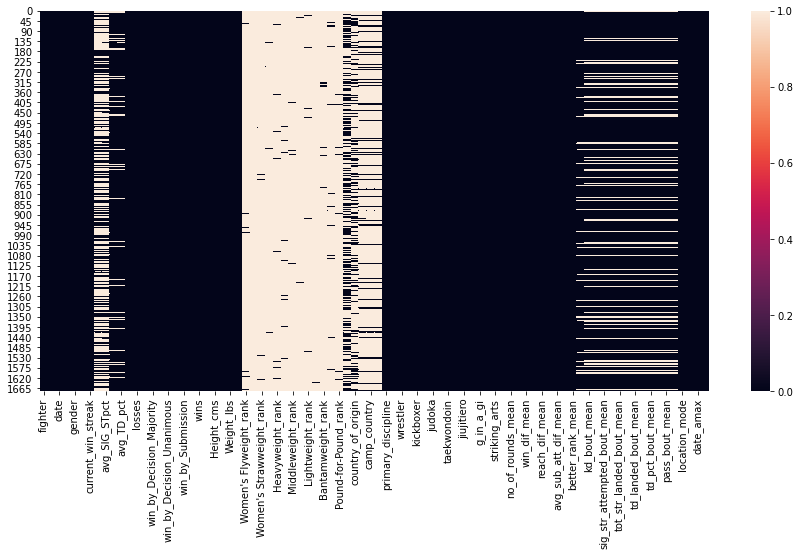

In [55]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.heatmap(df.isnull(), ax=ax)

probs should reduce this down to just the columns with NULLs in it for readability actually...

looks like we loose about 100 fighters nationalities compared to the size of that file. I guess we're going to have to do some more thorough cleaning of the data prior to the join, most likely on the per_fight csv rather than the nationality one

<AxesSubplot:>

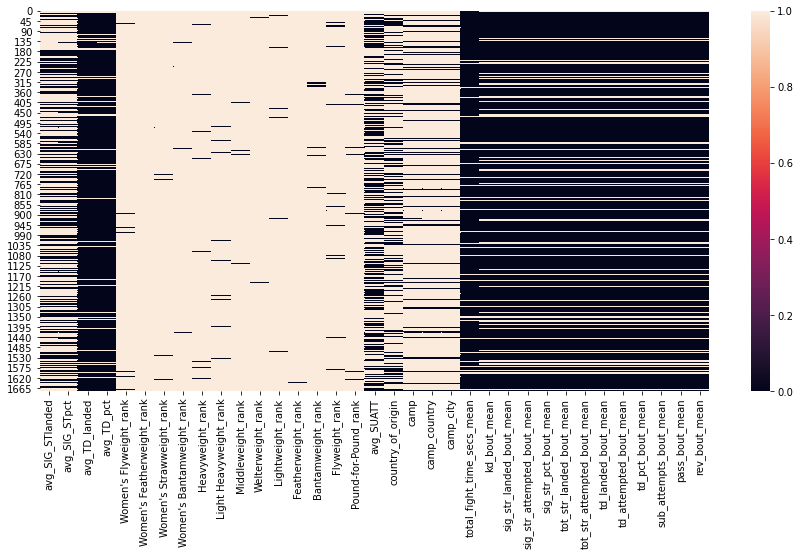

In [56]:
nulls = df.isnull()
nulls = nulls.loc[:, nulls.any()].columns  # get only columns with at least one NULL in

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(df[nulls].isnull(), ax=ax)

The rank variables are massively NULL, which is to be expected as only the top 15 fighters in each weightclass are ranked, though I guess since I'm not scraping current ranks, its possible for fighters who havent fought since loosing / gaining rank status wil incorrectly have a filled or NULL value in these columns respectively (especially true for retired fighters who went out relatively well respected). 

Beyond that we see that camp dataset is largely useless which to be fair is as expected. We also see that the mean statistics per fighter are often NULL for the same row i.e. a given fighter will be all NULL for these columns or not. It remains to be seen why that might be the case.

for the default second graph we'll do the unique value count of the non numeric columns just to get a feel for how much variety we're seeing there.

<AxesSubplot:>

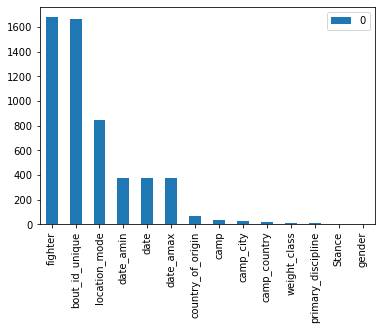

In [57]:
objs = df.select_dtypes(include=[object])
objs = pd.DataFrame(objs.nunique())
objs.sort_values(by=0, ascending=False, inplace=True)
objs.plot(kind='bar')

I'm supprised by location_mode having so many unqiue values, as that points to the city most commonly fought in, which I expected to be majority Vegas? I guess the next thing I'll look at is some spatial analysis then.

## Aforementioned Spatial Analysis Then

choropleth with the boiiiiis...

In all seriousness, we'll choropleth both country of origin and location_mode. First up, we'll cover the issue with location_mode. This variable comes wth it a question of what to do with multimodal values, which currently are saved as lists which is obviously a massive knob. The obvious options would be:

- pick a random mode to be the true mode
- pick the mode which is otherwise the most popular under the assumption that given more fights, this will be the location the fighter will revisit most often
- split the vote between all options either with or without weighting

beyond that the locations are also given as (city, country) pairings, or occasionally (city, region, country), so there is also the question of how gritty we can plot. I'm thinking in particular that splitting the US by state but everything else by country would be a decent way to do it?

for country_of_origin things look a lot more straight forwards, although some of the country names might need a bit of editing to match up to the standard polygon names (i.e. 'Russian Federation' isnt how Russia is typically labelled). 

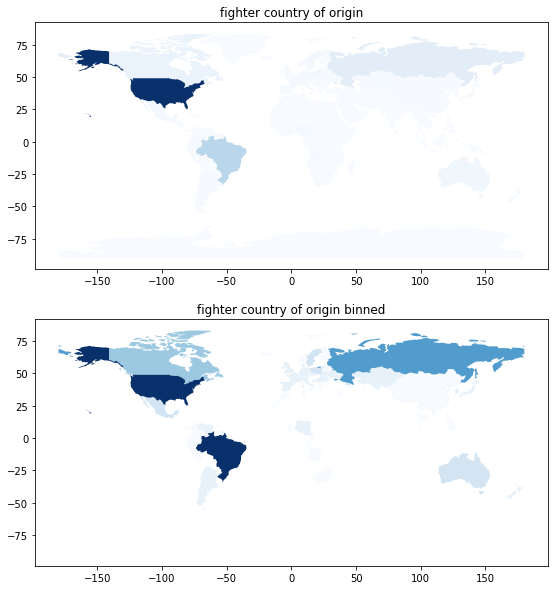

In [33]:
countries_polygons = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries_polygons.drop(['pop_est', 'gdp_md_est'], axis=1, inplace=True)

countries_of_origin = pd.DataFrame(df.groupby('country_of_origin').count()['fighter']).reset_index()
country_map = [['Hong Kong', 'China'],
               ['United States', 'United States of America'],
               ['Wales', 'United Kingdom'],
               ['Scotland', 'United Kingdom'],
               ['England', 'United Kingdom'],
               ['Czech Republic', 'Czechia'],
               ['Russian Federation', 'Russia'],
               ['North Macedonia', 'Macedonia'],
               ['Democratic Republic Congo', 'Congo'],
               ['Bosnia Herzegovina', 'Bosnia and Herz.'],
               ['Northern Mariana Islands', 'Philippines'],
               ['Guam', 'Philippines']]

for country in country_map:
    countries_of_origin.loc[countries_of_origin.country_of_origin == country[0], 'country_of_origin'] = country[1]

countries_of_origin = pd.merge(countries_of_origin, countries_polygons, left_on='country_of_origin',
                               right_on='name', how='outer')
countries_of_origin.fighter.fillna(0, inplace=True)
countries_of_origin = gpd.GeoDataFrame(countries_of_origin)


bins = [0, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, float('inf')]
labels = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 51]
countries_of_origin['fighter_binned'] = pd.cut(countries_of_origin['fighter'], bins=bins, labels=labels)

fig, ax = plt.subplots(2, figsize=(15, 10))

countries_of_origin.plot(column='fighter', cmap='Blues', figsize=(7.5, 5), ax=ax[0])
ax[0].set_title('fighter country of origin')
countries_of_origin.plot(column='fighter_binned', cmap='Blues', figsize=(7.5, 5), ax=ax[1])
ax[1].set_title('fighter country of origin binned')

plt.show()

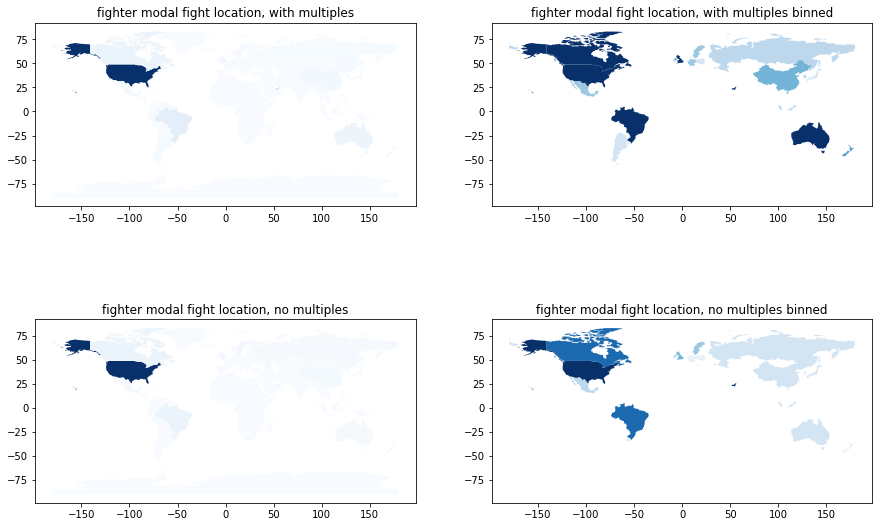

In [58]:
replacements = {'USA': 'United States of America',
                'Singapore': 'Malaysia'}

modal_locs_list = df['location_mode'].tolist()

modal_locs = [loc.replace('\n', '').split("' '")[0].split(',')[-1].strip() for loc in modal_locs_list]
modal_locs = [replacements.get(x, x) for x in modal_locs]
modal_locs = pd.DataFrame.from_dict(dict(Counter(modal_locs)), orient='index').reset_index()
modal_locs.columns = ['loc', 'count']

modal_locs_no_multis = [loc.replace('\n', '').split("' '")[0].split(',')[-1].strip() for loc in modal_locs_list
                        if '[' not in loc]
modal_locs_no_multis = [replacements.get(x, x) for x in modal_locs_no_multis]
modal_locs_no_multis = pd.DataFrame.from_dict(dict(Counter(modal_locs_no_multis)), orient='index').reset_index()
modal_locs_no_multis.columns = ['loc', 'count_no_multis']

modal_locs = pd.merge(modal_locs, countries_polygons, left_on='loc', right_on='name', how='outer')
modal_locs = pd.merge(modal_locs, modal_locs_no_multis, on='loc', how='outer')
modal_locs['count'].fillna(0, inplace=True)
modal_locs['count_no_multis'].fillna(0, inplace=True)
modal_locs = gpd.GeoDataFrame(modal_locs)

bins = [0, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, float('inf')]
labels = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 51]
modal_locs['modal_loc_binned'] = pd.cut(modal_locs['count'], bins=bins, labels=labels)
modal_locs['modal_loc_no_multis_binned'] = pd.cut(modal_locs['count_no_multis'], bins=bins, labels=labels)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

modal_locs.plot(column='count', cmap='Blues', figsize=(7.5, 5), ax=ax[0, 0])
ax[0, 0].set_title('fighter modal fight location, with multiples')
modal_locs.plot(column='modal_loc_binned', cmap='Blues', figsize=(7.5, 5), ax=ax[0, 1])
ax[0, 1].set_title('fighter modal fight location, with multiples binned')
modal_locs.plot(column='count_no_multis', cmap='Blues', figsize=(7.5, 5), ax=ax[1, 0])
ax[1, 0].set_title('fighter modal fight location, no multiples')
modal_locs.plot(column='modal_loc_no_multis_binned', cmap='Blues', figsize=(7.5, 5), ax=ax[1, 1])
ax[1, 1].set_title('fighter modal fight location, no multiples binned')

plt.show()

as expected the USA comes out as king, primarily due to all the las vegas fights (~1000 / 1600 fighters have at least one mode occuring there). Interesting to see some of the other countries that have the most modes, as they dont really match up with the fighters countris of origin as we know them. (for instance we dont see many Canadian or Arabian fighters, yet these two countries each have over a hundred modes. 

the graphs labelled 'no multiples' have had multimodals removed entirely. not sure if that was the best way to deal with them but thats how ive opted to do it. hasnt made a huge difference other than reducing the numbers in like UK, Canada, Brazil and most interstingly australia. I'd be interested to know why that migth be - potentially lots of smaller fighters who'd prefer to fight on local cards / vegas cards only?

next up, I'll have a fiddle with the mean stats. I'd imagine this will be a kooky one :O